# Spark SQL

Before you begin, make sure that you've installed spark of version `2.3` or higher (see `README.md`)

**Links**

* https://spark.apache.org/docs/latest/sql-getting-started.html

In [1]:
!pwd && ls -lah | grep README

/workspace/spark_sql/notebooks
-rw-r--r-- 1 root root 1.2K Feb  4 16:31 README.md


## Запуск spark

In [2]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession


spark = SparkSession \
    .builder \
    .master('local[*]') \
    .appName("spark_sql_examples") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "16g") \
    .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [3]:
DATA_PATH = '/workspace/data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

---
## DataFrame creation

DataFrame можно создать несколькими способами:

* из файла
* из существующего RDD
* из другого DataFrame'a

### From file

В случае с созданием из csv файла, может понадобится указать схему

In [4]:
from pyspark.sql.types import *


schema = StructType([
    StructField('user_id', IntegerType()),
    StructField('movie_id', IntegerType()),
    StructField('rating', FloatType()),
    StructField('timestamp', IntegerType())
])

ratings_df = sqlContext.read \
    .format('com.databricks.spark.csv') \
    .schema(schema) \
    .options(header='true', delimiter=',') \
    .load('file:///' + RATINGS_PATH)

In [5]:
ratings_df.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: float (nullable = true)
 |-- timestamp: integer (nullable = true)



In [6]:
ratings_df.take(5)

[Row(user_id=1, movie_id=296, rating=5.0, timestamp=1147880044),
 Row(user_id=1, movie_id=306, rating=3.5, timestamp=1147868817),
 Row(user_id=1, movie_id=307, rating=5.0, timestamp=1147868828),
 Row(user_id=1, movie_id=665, rating=5.0, timestamp=1147878820),
 Row(user_id=1, movie_id=899, rating=3.5, timestamp=1147868510)]

### From RDD

Для того чтобы построить DataFrame из RDD нужно у RDD вызвать метод `toDF`.

*Remark:* RDD можно получить из DataFrame с помощью аттрибута `rdd`.

In [7]:
ratings = sc.textFile('file:///' + RATINGS_PATH)

In [8]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [9]:
from pyspark.sql import Row


ratings_df = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Row(user_id=int(arr[0]), 
                         movie_id=int(arr[1]), 
                         rating=float(arr[2]), 
                         timestamp=int(arr[3])))\
    .toDF()

In [10]:
ratings_df.printSchema()

root
 |-- movie_id: long (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: long (nullable = true)



---
## DataFrame API

In [11]:
import pyspark.sql.functions as F


movies_df = sqlContext.read.format("com.databricks.spark.csv") \
    .option("delimiter", ",") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load('file:///' + MOVIES_PATH)

In [12]:
movies_df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)



### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг.

Сравните код ниже с кодом, использующим RDD API (см. `apache_spark/notebooks/spark_examples.ipynb`):

```
ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1]) \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)
```

In [13]:
ratings_df \
    .groupby('movie_id') \
    .agg(F.mean('rating').alias('mean_rating'), 
         F.count('rating').alias('ratings_count')) \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId'], how='inner') \
    .sort(F.col('mean_rating').desc()) \
    .take(10)

[Row(movie_id=159053, mean_rating=5.0, ratings_count=1, movieId=159053, title='In Her Line of Fire (2006)', genres='Action|Drama|Thriller'),
 Row(movie_id=199756, mean_rating=5.0, ratings_count=1, movieId=199756, title='Zum Teufel mit der Penne (1968)', genres='Comedy'),
 Row(movie_id=174971, mean_rating=5.0, ratings_count=1, movieId=174971, title='This Thing of Ours (2005)', genres='Action|Drama|Thriller'),
 Row(movie_id=209155, mean_rating=5.0, ratings_count=1, movieId=209155, title='Santosh Subramaniam (2008)', genres='Action|Comedy|Romance'),
 Row(movie_id=123959, mean_rating=5.0, ratings_count=1, movieId=123959, title='Groupie (2010)', genres='Horror|Thriller'),
 Row(movie_id=144200, mean_rating=5.0, ratings_count=1, movieId=144200, title='Lonely Boy (2013)', genres='Comedy|Drama'),
 Row(movie_id=145060, mean_rating=5.0, ratings_count=1, movieId=145060, title='Tales From the Dark 1 (2013)', genres='Horror'),
 Row(movie_id=145232, mean_rating=5.0, ratings_count=1, movieId=145232, t

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [14]:
movies_frequency_pdf = ratings_df \
    .groupby('movie_id') \
    .count() \
    .join(movies_df, ratings_df['movie_id'] == movies_df['movieId']) \
    .sort(F.col('count').desc()) \
    .toPandas()

In [15]:
movies_frequency_pdf.head(10)

,movie_id,count,movieId,title,genres
0,356,81491,356,Forrest Gump (1994),Comedy|Drama|Romance|War
1,318,81482,318,"Shawshank Redemption, The (1994)",Crime|Drama
2,296,79672,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,74127,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,72674,2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,260,68717,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,480,64144,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,527,60411,527,Schindler's List (1993),Drama|War
8,110,59184,110,Braveheart (1995),Action|Drama|War
9,2959,58773,2959,Fight Club (1999),Action|Crime|Drama|Thriller


---
## SQL

In [16]:
ratings_df.createTempView('ratings')
movies_df.createTempView('movies')

In [17]:
query = """
    SELECT movie_id, COUNT(*), first(title) as title
    FROM ratings INNER JOIN movies ON ratings.movie_id == movies.movieId
    WHERE movies.title LIKE '%(1994)%'
    GROUP BY movie_id
    ORDER BY COUNT(*) DESC
"""

movies_frequency = spark.sql(query)
movies_frequency.show()

+--------+--------+--------------------+
|movie_id|count(1)|               title|
+--------+--------+--------------------+
|     356|   81491| Forrest Gump (1994)|
|     318|   81482|Shawshank Redempt...|
|     296|   79672| Pulp Fiction (1994)|
|     364|   42745|Lion King, The (1...|
|     380|   41673|    True Lies (1994)|
|     377|   41302|        Speed (1994)|
|     344|   37453|Ace Ventura: Pet ...|
|     367|   34621|    Mask, The (1994)|
|     293|   33680|Léon: The Profess...|
|     231|   31843|Dumb & Dumber (Du...|
|     316|   30910|     Stargate (1994)|
|     349|   27766|Clear and Present...|
|     253|   27577|Interview with th...|
|     357|   26709|Four Weddings and...|
|     329|   24615|Star Trek: Genera...|
|     223|   24050|       Clerks (1994)|
|     288|   23259|Natural Born Kill...|
|     300|   18997|    Quiz Show (1994)|
|     368|   16475|     Maverick (1994)|
|     353|   16219|    Crow, The (1994)|
+--------+--------+--------------------+
only showing top

In [18]:
spark.sql(query).explain(True)

== Parsed Logical Plan ==
'Sort ['COUNT(1) DESC NULLS LAST], true
+- 'Aggregate ['movie_id], ['movie_id, unresolvedalias('COUNT(1), None), first('title, false) AS title#131]
   +- 'Filter 'movies.title LIKE %(1994)%
      +- 'Join Inner, ('ratings.movie_id = 'movies.movieId)
         :- 'UnresolvedRelation `ratings`
         +- 'UnresolvedRelation `movies`

== Analyzed Logical Plan ==
movie_id: bigint, count(1): bigint, title: string
Project [movie_id#12L, count(1)#134L, title#131]
+- Sort [count(1)#134L DESC NULLS LAST], true
   +- Aggregate [movie_id#12L], [movie_id#12L, count(1) AS count(1)#134L, first(title#31, false) AS title#131]
      +- Filter title#31 LIKE %(1994)%
         +- Join Inner, (movie_id#12L = cast(movieId#30 as bigint))
            :- SubqueryAlias `ratings`
            :  +- LogicalRDD [movie_id#12L, rating#13, timestamp#14L, user_id#15L], false
            +- SubqueryAlias `movies`
               +- Relation[movieId#30,title#31,genres#32] csv

== Optimized Logica

---
## User Defined Function (UDF)


### Количество вышедших фильмов по годам

Мы знаем, что название фильма содержит информацию о дате выхода

In [19]:
import re


def get_release_year(title):
    result = re.match(r'.*(\(\d+\))', title)
    return int(result.group(1)[1:-1]) if result is not None else None


get_release_year_udf = F.udf(get_release_year, IntegerType())

In [20]:
relase_count_by_year = movies_df \
    .withColumn('year', get_release_year_udf('title')) \
    .filter(F.col('year').isNotNull()) \
    .groupby('year') \
    .count() \
    .toPandas()

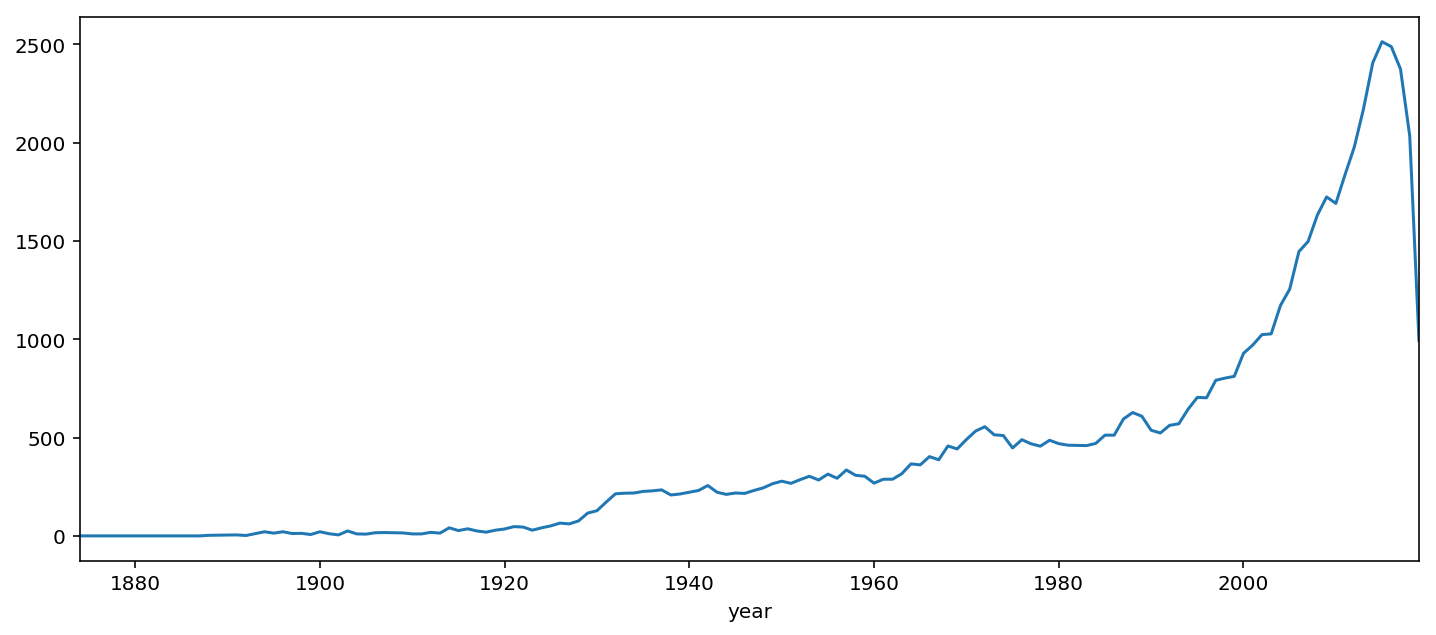

In [21]:
plt.figure(figsize=(12, 5))
relase_count_by_year.sort_values('year').set_index('year')['count'].plot()
plt.show()

---
## Window Functions

Хотим понять, сколько времени проходит между последовательными оценками для пользователей, более формально:

Для пользователя $u$ есть последовательность $(m_1, r_1, t_1), \ldots, (m_n, r_n, t_n)$, где $t_i \leq t_{i+1}$. Рассмотрим последовательность $\Delta_i = t_{i+1} - t_i$, для $i=1,\ldots,n-1$.

Хотим построить распределение величины $\Delta_i$ используя информацию обо всех пользователях.

In [22]:
from pyspark.sql.window import Window


user_window = Window.orderBy('timestamp').partitionBy('user_id')

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .take(10)

[Row(movie_id=2161, rating=3.5, timestamp=1280513623, user_id=26, next_timestamp=1280513649),
 Row(movie_id=455, rating=3.0, timestamp=1280513649, user_id=26, next_timestamp=1280513679),
 Row(movie_id=1037, rating=2.5, timestamp=1280513679, user_id=26, next_timestamp=1280513702),
 Row(movie_id=1586, rating=3.0, timestamp=1280513702, user_id=26, next_timestamp=1280513710),
 Row(movie_id=54286, rating=4.0, timestamp=1280513710, user_id=26, next_timestamp=1280513785),
 Row(movie_id=4023, rating=3.0, timestamp=1280513785, user_id=26, next_timestamp=1280513802),
 Row(movie_id=54503, rating=2.0, timestamp=1280513802, user_id=26, next_timestamp=1280513817),
 Row(movie_id=3173, rating=3.5, timestamp=1280513817, user_id=26, next_timestamp=1280513893),
 Row(movie_id=53322, rating=4.0, timestamp=1280513893, user_id=26, next_timestamp=1280513897),
 Row(movie_id=2764, rating=4.5, timestamp=1280513897, user_id=26, next_timestamp=1280513931)]

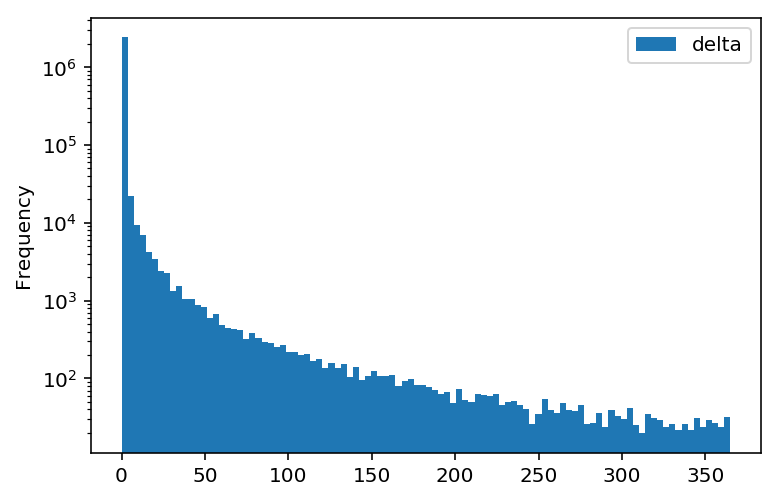

In [23]:
DAY = 24 * 60 * 60

ratings_df \
    .withColumn('next_timestamp', F.lead('timestamp').over(user_window)) \
    .filter(F.col('next_timestamp').isNotNull()) \
    .withColumn('delta', (F.col('next_timestamp') - F.col('timestamp')) / F.lit(DAY)) \
    .select('delta') \
    .filter(F.col('delta') <= 365) \
    .sample(False, 0.1) \
    .toPandas().plot.hist(bins=100, logy=True)

# Упражнения. Recommender System

Пусть $U$ - множество пользователей, $I$ - множество фильмов, и $R = (r_{ui})$ - матрица рейтингов. 

Через $R_u$ будем обозначать строку матрицы $R$, соотвествующую пользователю $u$.

## Генерируем выборку

На всём наборе данных запросы выполняются очень долго, поэтому в доманего задания выборка была уменьшена.

In [42]:
small_users = ratings_df\
    .groupby('user_id')\
    .agg(F.count('movie_id').alias('ratings_cnt')) \
    .select('user_id', 'ratings_cnt')\
    .sample(fraction=5000/162541, seed=239566, withReplacement=False)\
    .persist()

In [43]:
small_ratings = ratings_df\
    .join(small_users, small_users["user_id"] == ratings_df["user_id"], "leftsemi")\
    .persist()

In [46]:
marks_counts = small_ratings\
    .groupby('movie_id') \
    .agg(F.count('user_id').alias('ratings_cnt')) \
    .persist()

In [44]:
print(small_users.count())

5013


In [45]:
print(small_ratings.count())

762008


In [47]:
print(marks_counts.count())

18907


---

## Most similar items

Для каждого фильма $i$ определим множество $U(i) = \{ u \in U \mid r_{ui} \neq 0 \}$ - множество пользователей, поставивших фильму $i$ оценку.

Тогда мы можем определить множество $I(i) = \left\{ i' \in I ~\Big|~ sim(i, i') = \frac{|U(i) ~\cap~ U(i')|}{|U(i) ~\cup~ U(i')|} > \delta \right\}$ - множество похожих фильмов.

Можно отсортировать элементы множества $I(i)$ по неубыванию $sim(i, i')$.

Реализуйте функцию, которая на вход получает `movie_id` и возвращает топ `N` фильмов отранжированных по $sim$.

In [52]:
def request_closest(request_marks, marks, marks_counts, N):
    return request_marks.alias("request")\
        .join(marks.alias("base"), F.col("request.user_id") == F.col("base.user_id"))\
        .select(
            F.col("request.movie_id").alias("request_id"), 
            F.col("base.movie_id").alias("movie_id"), 
            F.col("base.user_id").alias("user_id"))\
        .filter(F.col('request_id') != F.col('movie_id')) \
        .groupby('request_id', 'movie_id')\
        .agg(F.count('user_id').alias('common_users'))\
        .alias("intersection")\
        .join(marks_counts.alias("request_cnts"), F.col("request_cnts.movie_id") == F.col("intersection.request_id"))\
        .join(marks_counts.alias("movie_cnts"), F.col("movie_cnts.movie_id") == F.col("intersection.movie_id"))\
        .select(
            F.col("intersection.request_id").alias("request_id"),
            F.col("intersection.movie_id").alias("movie_id"),
            F.col("intersection.common_users").alias("intersection_cnt"),
            F.col("request_cnts.ratings_cnt").alias("request_cnt"),
            F.col("movie_cnts.ratings_cnt").alias("movie_cnt"))\
        .withColumn('sim', 
                    F.col('intersection_cnt') / (F.col('request_cnt') + F.col('movie_cnt') - F.col('intersection_cnt')))\
        .drop('intersection_cnt', 'request_cnt', 'movie_cnt')\
        .withColumn('sim_rank', 
                    F.rank().over(
                        Window.partitionBy('request_id')
                            .orderBy(F.col('sim').desc())))\
        .filter(F.col("sim_rank") <= N)

    
def get_n_closest(movie_id, N):
    return request_closest(
            small_ratings.filter(small_ratings["movie_id"] == movie_id),
            small_ratings,
            marks_counts,
            N)\
        .sort(F.col('sim').desc())\
        .drop("request_id", "sim_rank")

In [53]:
request_closest(small_ratings.where(small_ratings['movie_id'] < 10), small_ratings, marks_counts, 5).printSchema()

root
 |-- request_id: long (nullable = true)
 |-- movie_id: long (nullable = true)
 |-- sim: double (nullable = true)
 |-- sim_rank: integer (nullable = true)



In [195]:
get_n_closest(7, 5).take(5)

[Row(movie_id=708, sim=0.29709035222052066),
 Row(movie_id=3, sim=0.2833333333333333),
 Row(movie_id=5, sim=0.24546952224052718),
 Row(movie_id=802, sim=0.2403225806451613),
 Row(movie_id=494, sim=0.23895253682487724)]

Построим несколько вариантов простой Рекомендательной Системы.

*Основная цель:* порекомендовать фильм пользователю. (Для простоты опустим информацию о самих рейтингах)

## Methods

При разработке сложных методов, сначала нужно выбрать несколько простотых методов (`Baseline`), относительно которых мы будем сравнивать новый метод.

In [55]:
class AbstractMethod:
    def train(self, marks):
        pass
    
    def predict(self, users_id, N):
        pass

### POP

Будем всегда рекомендовать самые популярные фильмы (с наибольшим цислом оценок пользователей).

Не смотря на свою простоту, в ряде задач показывает себя достаточно хорошо.

In [79]:
class PopularRecommendation(AbstractMethod):
    
    def __init__(self, movies_base_limit=1000):
        self.movies_base_limit = movies_base_limit
    
    def train(self, marks):
        self.marks = marks.alias("train_marks")
        self.marks_counts = marks\
            .drop("timestamp", "rating")\
            .groupby('movie_id') \
            .agg(F.count('user_id').alias('ratings_cnt')) \
            .sort(F.col('ratings_cnt').desc()) \
            .limit(self.movies_base_limit)\
            .persist()
    
    def predict(self, users_id, N):
        return self.marks_counts\
            .crossJoin(users_id)\
            .alias("recommendation")\
            .join(self.marks, 
                  (F.col("train_marks.user_id") == F.col("recommendation.user_id")) & 
                      (F.col("train_marks.movie_id") == F.col("recommendation.movie_id")),
                  "leftanti")\
            .withColumn('rank', 
                    F.rank().over(
                        Window.partitionBy('user_id')
                            .orderBy(F.col('ratings_cnt').desc())))\
            .filter(F.col("rank") <= N)\
            .select(F.col("user_id").alias("request_id"), "movie_id", "rank")

### User-based Collaborative Filtering

1. Для пользователя $u$ определим множество похожих пользователей как 

$$U(u) = \left\{ u' \in U \mid sim(u, u') > \alpha \right\},$$

где $sim(u, u')$ — одна из возможных мер близости $u'$ к $u$, например, косинусная близость между $R_{u}$ и $R_{u'}$

2. $$I(u) = \left\{ i \in I ~\Big|~ B(i) = \frac{|U(u) ~\cap~ U(i)|}{|U(u) ~\cup~ U(i)|} > 0 \right\}$$


3. Отсортировать $i \in I(u)$ по убыванию $B(i)$, взять top $N$

In [215]:
class CollaborativeFilteringRecommendation(AbstractMethod):
    def __init__(self, alpha, movies_base_limit=1000):
        self.alpha = alpha
        self.movies_base_limit = movies_base_limit
    
    def train(self, marks):
        self.movie_count = marks\
            .groupby("movie_id")\
            .agg(F.count("user_id").alias("movie_cnt"))\
            .select("movie_id", "movie_cnt") \
            .sort(F.col('movie_cnt').desc()) \
            .limit(self.movies_base_limit)\
            .alias("movie_counts")\
            .persist()
        self.marks = marks\
            .join(self.movie_count, self.movie_count['movie_id'] == marks['movie_id'], "leftsemi")
        self.user_norm = self.marks\
            .withColumn("squared_rating", marks["rating"] * marks["rating"])\
            .groupby("user_id")\
            .agg(F.sum("squared_rating").alias("squared_norm"))\
            .withColumn("vec_norm", F.sqrt("squared_norm"))\
            .select("user_id", "vec_norm") \
            .persist()
            
    def predict(self, users_id, N):
        similar_users = self._get_similar_users(users_id)
        users_count = similar_users\
            .groupby("request_id")\
            .agg(F.count("user_id").alias("request_cnt"))\
            .select("request_id", "request_cnt")
        return similar_users\
            .join(self.marks, similar_users["user_id"] == self.marks["user_id"])\
            .select(
                similar_users["request_id"].alias("request_id"), 
                self.marks["movie_id"].alias("movie_id"), 
                similar_users["user_id"].alias("user_id"))\
            .groupby("request_id", "movie_id")\
            .agg(F.count("user_id").alias("common_cnt"))\
            .alias("intersection")\
            .join(self.movie_count, self.movie_count["movie_id"] == F.column("intersection.movie_id"))\
            .join(users_count, users_count["request_id"] == F.column("intersection.request_id"))\
            .select(
                F.col("intersection.request_id").alias("request_id"),
                F.col("intersection.movie_id").alias("movie_id"),
                F.col("intersection.common_cnt").alias("common_cnt"),
                self.movie_count["movie_cnt"].alias("movie_cnt"),
                users_count["request_cnt"].alias("request_cnt"))\
            .withColumn("sim", 
                        F.col("common_cnt") / (F.col("movie_cnt") + F.col("request_cnt") - F.col("common_cnt")))\
            .select('request_id', 'movie_id', 'sim')\
            .alias('options')\
            .join(self.marks.alias("base"), 
                  (F.col("options.request_id") == F.col("base.user_id")) & 
                      (F.col("options.movie_id") == F.col("base.movie_id")),
                  "leftanti")\
            .withColumn('rank', 
                    F.rank().over(
                        Window.partitionBy('request_id')
                            .orderBy(F.col('sim').desc())))\
            .filter(F.col("rank") <= N)\
            .select("request_id", "movie_id", "rank")
            
        
    def _get_similar_users(self, users_ids):
        return self.marks\
            .join(users_ids, self.marks["user_id"] ==  users_ids["user_id"], "leftsemi")\
            .alias("request")\
            .join(self.marks.alias("base"), F.col("request.movie_id") == F.col("base.movie_id"))\
            .withColumn("rating_prod", F.col("base.rating") * F.col("request.rating"))\
            .select(
                F.col("request.user_id").alias("request_id"), 
                F.col("base.user_id").alias("user_id"), 
                F.col("rating_prod"))\
            .filter(F.col('request_id') != F.col('user_id')) \
            .groupby('request_id', 'user_id')\
            .agg(F.sum('rating_prod').alias('dot'))\
            .alias("dot_holder")\
            .join(self.user_norm.alias("request_norm"), F.col("request_norm.user_id") == F.col("dot_holder.request_id"))\
            .join(self.user_norm.alias("user_norm"), F.col("user_norm.user_id") == F.col("dot_holder.user_id"))\
            .withColumn('cos_sim', 
                    F.col('dot_holder.dot') / (F.col('request_norm.vec_norm') * F.col('user_norm.vec_norm')))\
            .filter(F.col("cos_sim") >= self.alpha)\
            .select(
                F.col("dot_holder.request_id").alias("request_id"),
                F.col("dot_holder.user_id").alias("user_id"))      

In [245]:
tmp = CollaborativeFilteringRecommendation(0.01)
tmp.train(small_ratings)
tmp.predict(request, 10).take(20)

[Row(request_id=7, movie_id=296, rank=1),
 Row(request_id=7, movie_id=356, rank=2),
 Row(request_id=7, movie_id=593, rank=3),
 Row(request_id=7, movie_id=318, rank=4),
 Row(request_id=7, movie_id=527, rank=5),
 Row(request_id=7, movie_id=480, rank=6),
 Row(request_id=7, movie_id=2571, rank=7),
 Row(request_id=7, movie_id=260, rank=8),
 Row(request_id=7, movie_id=110, rank=9),
 Row(request_id=7, movie_id=589, rank=10),
 Row(request_id=6, movie_id=318, rank=1),
 Row(request_id=6, movie_id=356, rank=2),
 Row(request_id=6, movie_id=296, rank=3),
 Row(request_id=6, movie_id=593, rank=4),
 Row(request_id=6, movie_id=2571, rank=5),
 Row(request_id=6, movie_id=260, rank=6),
 Row(request_id=6, movie_id=480, rank=7),
 Row(request_id=6, movie_id=527, rank=8),
 Row(request_id=6, movie_id=110, rank=9),
 Row(request_id=6, movie_id=1196, rank=10)]

### Item-kNN

1. Для пользователя $u$ мы знаем $R(u) = \{ i \in I \mid r_{ui} \neq 0 \} $


2. Для каждого $i \in R(u)$ построим $I(i)$ - множество похожих фильмов


3. Отсортируем элементы множества $ \bigcup_{i \in R(u)} I(i) $, возьмем top $N$

In [260]:
class IkNNRecommendation(AbstractMethod):
    
    def __init__(self, movies_base_limit=1000):
        self.movies_base_limit = movies_base_limit
    
    def train(self, marks):
        self.marks_counts = marks\
            .groupby('movie_id') \
            .agg(F.count('user_id').alias('marks_cnt')) \
            .sort(F.col('marks_cnt').desc()) \
            .limit(self.movies_base_limit)\
            .alias("marks_counts")\
            .persist()
        self.marks = marks\
            .select('movie_id', 'user_id')\
            .join(self.marks_counts, marks["movie_id"] == self.marks_counts["movie_id"], "leftsemi")\
            .persist()
        
    def predict(self, users_ids, N):
        return self.marks\
            .join(users_ids, self.marks["user_id"] ==  users_ids["user_id"], "leftsemi")\
            .alias("request")\
            .crossJoin(self.marks.alias("base"))\
            .select(
                F.col("request.user_id").alias("request_id"), 
                F.col("request.movie_id").alias("request_movie_id"), 
                F.col("base.movie_id").alias("movie_id"), 
                F.col("base.user_id").alias("user_id"))\
            .filter(F.col('request_movie_id') != F.col('movie_id')) \
            .filter(F.col('request_id') != F.col('user_id')) \
            .groupby('request_id', 'request_movie_id', 'movie_id')\
            .agg(F.count('user_id').alias('common_users'))\
            .alias("intersection")\
            .join(self.marks_counts.alias("request_cnts"), F.col("request_cnts.movie_id") == F.col("intersection.request_movie_id"))\
            .join(self.marks_counts.alias("movie_cnts"), F.col("movie_cnts.movie_id") == F.col("intersection.movie_id"))\
            .select(
                F.col("intersection.request_id").alias("request_id"),
                F.col("intersection.request_movie_id").alias("request_movie_id"),
                F.col("intersection.movie_id").alias("movie_id"),
                F.col("intersection.common_users").alias("intersection_cnt"),
                F.col("request_cnts.marks_cnt").alias("request_cnt"),
                F.col("movie_cnts.marks_cnt").alias("movie_cnt"))\
            .withColumn('sim', 
                    F.col('intersection_cnt') / (F.col('request_cnt') + F.col('movie_cnt') - F.col('intersection_cnt')))\
            .groupby("request_id", "movie_id")\
            .agg(F.max("sim").alias("sim"))\
            .alias('options')\
            .join(self.marks.alias("database"), 
                  (F.col("options.request_id") == F.col("database.user_id")) & 
                      (F.col("options.movie_id") == F.col("database.movie_id")),
                  "leftanti")\
            .withColumn('rank', 
                    F.dense_rank().over(
                        Window.partitionBy('request_id',)
                            .orderBy(F.col('sim').desc())))\
            .filter(F.col("rank") <= N)\
            .select("request_id", "movie_id", "rank")

In [261]:
trm = IkNNRecommendation()
trm.train(small_ratings)
trm.predict(small_ratings, 10).printSchema()

root
 |-- request_id: long (nullable = true)
 |-- movie_id: long (nullable = true)
 |-- rank: integer (nullable = true)



## Evaluation Protocol

Теперь опишем, как будем оценивать качество рассматриваемых методов.

### Data Splits

Так как в данных `ratings` есть поле `timestamp`, то для каждого пользователя отсортируем его рейтинги по времени и первые $80\%$ рейтингов отнесем в `Train`, еще $10\%$ в `Validation`, и остальное в `Test`.


In [176]:
small_users.count()

5013

In [177]:
dataset = small_ratings\
            .withColumn('rank', 
                    F.rank().over(
                        Window.partitionBy('user_id',)
                            .orderBy(F.col('timestamp').asc())))\
            .join(small_users, small_users["user_id"] == small_ratings["user_id"])\
            .select(
                small_ratings["user_id"].alias("user_id"),
                small_ratings["movie_id"].alias("movie_id"),
                small_ratings["rating"].alias("rating"),
                "rank",
                small_users["ratings_cnt"].alias("ratings_cnt"))\
            .persist()

In [178]:
train = dataset.filter(F.col("ratings_cnt") * 0.8 > F.col("rank"))\
    .drop("rank", "ratings_cnt")\
    .persist()

In [179]:
validate = dataset.filter((F.col("ratings_cnt") * 0.8 <= F.col("rank")) & (F.col("ratings_cnt") * 0.9 > F.col("rank")))\
    .drop("rank", "ratings_cnt")\
    .persist()

In [180]:
test = dataset.filter(F.col("ratings_cnt") * 0.9 <= F.col("rank"))\
    .drop("rank", "ratings_cnt")\
    .persist()

In [175]:
test.count()

76997

In [267]:
small_test_users = test\
    .select("user_id")\
    .distinct()\
    .sample(fraction=5/5000, seed=1235, withReplacement=False)\
    .alias("small_test_users")\
    .persist()

In [268]:
small_test = test\
    .join(small_test_users, small_test_users["user_id"] == test["user_id"], "left_semi")\
    .alias("small_test")\
    .persist()

### Metrics

В `Test` для каждого пользователя есть `user_id, R_u`, где $R_u$ - множество фильмов, которым он поставил оценку. Для того чтобы оценить качество рассматриваемых методов будем для пользователя строить список из $N$ рекомендаций $\hat{R}_{1\colon N}$ и считать метрики.

* $$ Precision@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{N} $$
* $$ Recall@N = \frac{|R_u \cap \hat{R}_{1\colon N} |}{|R_u|} $$
* $Map@N$

где $N \in \{1,5,10\}$

https://spark.apache.org/docs/latest/mllib-evaluation-metrics.html#ranking-systems

In [ ]:
import numpy as np

def get_metrics(test, predictions, ns):
    tp = test\
        .join(predictions, 
              (test["user_id"] == predictions["request_id"]) & (test["movie_id"] == predictions["movie_id"]),
             "inner")\
        .select(
            test["user_id"].alias("user_id"), 
            predictions["rank"])\
        .alias("tp")
    test_counts = test\
        .groupby("user_id")\
        .agg(F.count('movie_id').alias('m'))\
        .select("user_id", "m")\
        .alias("user_m")
    result = test_counts\
        .join(tp, tp["user_id"] == test_counts["user_id"], "left")\
        .select(
            tp["user_id"].alias("user_id"),
            tp["rank"].alias("rank"),
            test_counts["m"].alias("m"))\
        .alias("result")\
        .persist()
    N = max(ns)
    num_users = test_counts.count()
    print(num_users)
    precisions = []
    recalls = []
    for i in range(1, N + 1):
        metrics = result\
            .filter((result["rank"] <= i) | (result["rank"] == None))\
            .groupby("user_id")\
            .agg(F.count("rank").alias("tp"), F.min("m").alias("m"))\
            .withColumn("precision", F.col("tp") / i)\
            .withColumn("recall", F.col("tp") / F.col("m"))\
            .select(F.sum("recall").alias("sum_recall"), F.sum("precision").alias("sum_precision"))\
            .collect()
        precisions.append(metrics[0].sum_precision / num_users)
        recalls.append(metrics[0].sum_recall / num_users)
            
            
    return [(precisions[n - 1], recalls[n - 1], np.mean(precisions[:n])) for n in ns]

## Experimental Results

Посмотрим на результаты

*Remark* скорее всего посчитать метрики для всех пользователей будет довольно долго - можно ограничится, например, случайными 10к пользователями

In [155]:
ns = [1, 5, 10]

### PopularRecommendation

In [201]:
pop = PopularRecommendation()
pop.train(train)
result = pop.predict(small_users.select("user_id"), 10).persist()
metrics = get_metrics(test, result, ns)

In [202]:
for metric_pack, n in zip(metrics, ns):
    precision, recall, MAP = metric_pack
    print("P@", n, " = ", precision, ",\tR@", n, " = ", recall, ",\tMAP@", n, " = ", MAP, sep='')

P@1 = 0.05467479674796748,	R@1 = 0.004956849797669468,	MAP@1 = 0.05467479674796748
P@5 = 0.044308943089430904,	R@5 = 0.023164098561375506,	MAP@5 = 0.04848915989159891
P@10 = 0.039349593495934955,	R@10 = 0.03918812469640851,	MAP@10 = 0.04489899503161698


### User-based Collaborative Filtering

In [225]:
cfr = CollaborativeFilteringRecommendation(0.5)
cfr.train(train)

result = cfr.predict(small_users.select("user_id"), 10).persist()
metrics = get_metrics(test, result, ns)

136984


In [226]:
for metric_pack, n in zip(metrics, ns):
    precision, recall, MAP = metric_pack
    print("P@", n, " = ", precision, ",\tR@", n, " = ", recall, ",\tMAP@", n, " = ", MAP, sep='')

P@1 = 0.01707317073170732,	R@1 = 0.001170444401960477,	MAP@1 = 0.01707317073170732
P@5 = 0.01813008130081302,	R@5 = 0.00871476346753608,	MAP@5 = 0.017470867208672088
P@10 = 0.018252032520325208,	R@10 = 0.01760218559887633,	MAP@10 = 0.01801502613240418


### Item-kNN

In [ ]:
kNN = IkNNRecommendation()
kNN.train(train)

result = kNN.predict(small_test_users.select("user_id"), 10).persist()
metrics = get_metrics(small_test, result, ns)

In [ ]:
result.take(20)